In [ ]:
# Core libs
import pandas as pd
import numpy as np

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
#pio.renderers.default = "browser"

# sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

# Drive connect
from google.colab import drive
drive.mount('/content/drive')

# Training

In [ ]:
## Custom metric
def mape_accuracy(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast( tf.abs((y_true - y_pred)/y_pred) < 0.1, tf.int32), axis=1)
    total = y_true.shape[1]

    return (correct/total)*100

def mape_accuracy_log10(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract(tf.pow(tf.constant(10, dtype=tf.float32),y_true),tf.pow(tf.constant(10, dtype=tf.float32),y_pred)),tf.pow(tf.constant(10, dtype=tf.float32),y_true))) < 0.1, tf.int32), axis=1)
    #correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract((y_true + out_center)*out_scale ,(y_pred + out_center)*out_scale),y_true)) < 0.1, tf.int32), axis=1)
    total = y_true.shape[1]

    return (correct/total)*100

## Loading data

In [ ]:
raw_data_master = pd.read_excel('drive/MyDrive/Documents/Universidad/data/ord80p.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x)
raw_test_master = pd.read_excel('drive/MyDrive/Documents/Universidad/data/ord20p.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x)

In [ ]:
#raw_data = raw_data_master[raw_data_master['Provincia'] == 'Chiclayo'].append(raw_data_master[raw_data_master['Provincia'] == 'Prov. Const. del Callao']).append(raw_data_master[raw_data_master['Provincia'] == 'Arequipa']).append(raw_data_master[raw_data_master['Provincia'] == 'Trujillo']).append(raw_data_master[raw_data_master['Provincia'] == 'Lima'])
#raw_data = raw_data_master.drop(raw_data.index)

def pre_process(raw_data, training = False):
  raw_data = raw_data[raw_data['Departamento'] == 'Lima'].copy()

  categoria_bien = {"Local Comercial" : "1",
                    "Departamento" : "2",
                    "Vivienda Unifamiliar" : "3",
                    "Industria" : "4",
                    "Estacionamiento/depósito (U.I.)" : "5",
                    "AVALUOS_TIPOS_INMUEBLE_VEHICULO" : "6",
                    "Intitución Educativa" : "7",
                    "Terreno Urbano" : "8",
                    "Almacén /Taller" : "9",
                    "Oficina" : "10",
                    "Hotel" : "11",
                    "Fundo Agrícola" : "12",
                    "Centro de Salud" : "13",
                    "Maquinaria y/o Equipo" : "0",
                    "Muebles y enseres" : "0"}

  conservacion = {"En proyecto" : "1",
                  "En construcción" : "2",
                  "Bueno - Regular" : "3",
                  "Regular" : "4",
                  "Regular - Malo" : "5",
                  "Bueno" : "6",
                  "Muy bueno" : "7",
                  "Malo" : "8"}

  metodo = {"Costos o reposición (directo)" : "1",
            "Comparación de mercado (directo)" : "2",
            "Renta o capitalización (indirecto)" : "3"}

  pocision = {
      "Exterior" : "1",
      "Interior" : "2"
  }

  colnames = ["FechadelInforme",
              "TipodeVia",
              "Estacionamiento",
              "Categoriadelbien",
              "Posicion",
              "Numerodefrentes",
              "Edad",
              "Elevador",
              "Estadodeconservacion",
              "MetodoRepresentado",
              "Areaterreno",
              "Areaconstruccion",
              "Valorcomercial"]

  
  epsilon = 0.0000001

  processed_data = raw_data.iloc[:,[0,1,6,10,11,12,13,14,15,16,17,18,19]].fillna(0.0)
  processed_data = processed_data.replace(categoria_bien).replace(conservacion).replace(metodo).replace(pocision)
  processed_data.columns = colnames

  processed_data = processed_data.applymap(lambda x : float(x.replace(',','')) if isinstance(x,str) else x)

  ground_truth = processed_data.Valorcomercial.to_numpy() if training else None

  processed_data = processed_data.applymap(lambda x : np.log10(x + epsilon))
  return processed_data, ground_truth

In [ ]:
trainer_data, train_gt = pre_process(raw_data_master, True)
tester_data, test_gt = pre_process(raw_data_master, True)
log_data = trainer_data.drop(['Valorcomercial'], axis=1)
log_test = tester_data.drop(['Valorcomercial'], axis=1)

## RUUUUUUUUUUUUN (Train)

In [ ]:
data_pca = PCA()
data_pca.fit(trainer_data)

print(['PC'+str(i+1)+' ({:.3f})%'.format(data_pca.explained_variance_ratio_[i]*100) for i in range(13)])
print(np.cumsum(data_pca.explained_variance_ratio_)*100)

['PC1 (33.837)%', 'PC2 (24.184)%', 'PC3 (18.878)%', 'PC4 (7.175)%', 'PC5 (6.573)%', 'PC6 (4.539)%', 'PC7 (3.773)%', 'PC8 (0.627)%', 'PC9 (0.284)%', 'PC10 (0.057)%', 'PC11 (0.042)%', 'PC12 (0.032)%', 'PC13 (0.000)%']
[ 33.83673796  58.02055724  76.89868052  84.07404353  90.64696518
  95.18620566  98.95876448  99.58567277  99.86978809  99.92665265
  99.968198    99.99994446 100.        ]


In [ ]:
data_pca.components_[:8,:].shape

(8, 13)

### S4D Jengi

In [ ]:
X = trainer_data.to_numpy().T
components = (data_pca.components_[:8,:]@X).T

Xin = Input(shape=(12,),name='In')
X = Dense(10,activation=tf.keras.activations.softsign)(Xin)
X = Dense(10,activation=tf.keras.activations.softsign)(X)
X = Dense(10,activation=tf.keras.activations.softsign)(X)
X = Dense(10,activation=tf.keras.activations.softsign)(X)
completion = Dense(1, activation='relu')(X)

S4D_jengi = Model(inputs = Xin, outputs = [completion], name = "S4D_Jengi")

full_pca_inference = Concatenate(axis=1, name = 'completion')([Xin,completion])
Yout = Lambda(lambda x : tf.transpose(data_pca.components_[:8,:]@tf.transpose(x)))(full_pca_inference)

Jengi_train = Model(inputs = Xin, outputs = [Yout], name = 'PCA_train')

In [ ]:
epochs     = 1500        # número de epocas
batch_size = 250         # tamaño del lote
alpha      = 0.0005     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

Jengi_train.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = 'mae',
                  metrics   = ['accuracy'])

history = Jengi_train.fit(x                = log_data,
                          y                = components,
                          batch_size       = batch_size,
                          epochs           = epochs,
                          validation_split = 0.2,
                          verbose          = 2)

Epoch 1/1500
93/93 - 3s - loss: 0.2930 - accuracy: 0.9510 - val_loss: 0.2628 - val_accuracy: 0.9602 - 3s/epoch - 34ms/step
Epoch 2/1500
93/93 - 0s - loss: 0.2355 - accuracy: 0.9661 - val_loss: 0.2082 - val_accuracy: 0.9713 - 309ms/epoch - 3ms/step
Epoch 3/1500
93/93 - 0s - loss: 0.1813 - accuracy: 0.9758 - val_loss: 0.1547 - val_accuracy: 0.9804 - 278ms/epoch - 3ms/step
Epoch 4/1500
93/93 - 0s - loss: 0.1293 - accuracy: 0.9835 - val_loss: 0.1044 - val_accuracy: 0.9870 - 293ms/epoch - 3ms/step
Epoch 5/1500
93/93 - 0s - loss: 0.0810 - accuracy: 0.9897 - val_loss: 0.0586 - val_accuracy: 0.9917 - 308ms/epoch - 3ms/step
Epoch 6/1500
93/93 - 0s - loss: 0.0397 - accuracy: 0.9953 - val_loss: 0.0254 - val_accuracy: 0.9976 - 270ms/epoch - 3ms/step
Epoch 7/1500
93/93 - 0s - loss: 0.0217 - accuracy: 0.9981 - val_loss: 0.0207 - val_accuracy: 0.9976 - 275ms/epoch - 3ms/step
Epoch 8/1500
93/93 - 0s - loss: 0.0204 - accuracy: 0.9978 - val_loss: 0.0206 - val_accuracy: 0.9981 - 277ms/epoch - 3ms/step
Ep

## Gumbo data-prep

In [ ]:
V_h = S4D_jengi.predict(log_data)

print(log_data.shape)
print(V_h.shape)

C = np.concatenate([log_data, V_h], axis = 1)

900/900 [==============================] - 1s 1ms/step
(28774, 12)
(28774, 1)


In [ ]:
Xp = (data_pca.components_[:8,:]@C.T).T
V_e = np.power(10,V_h)
Eps = V_e.T[0].shape - train_gt

In [ ]:
Eps

array([-131663, -265793,  -95975, ..., -238932,  -66706, -196040])

## S4D Gumbo

In [ ]:
Xin = Input(shape=(8,),name='In')
X = Dense(13,activation='relu')(Xin)
#X = Lambda(lambda x : tf.pow(tf.constant(10, dtype=tf.float32), x))(X)
#X = Dense(5,activation=tf.keras.activations.softsign)(X)
#X = Dense(5,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(7,activation=tf.keras.activations.softsign)(X)
X = Dense(1)(X)
Hout = LeakyReLU(alpha=0.3)(X)

S4D_Gumbo = Model(inputs = Xin, outputs = [Hout], name = 'S4D_Gumbo')

In [ ]:
epochs     = 10000       # número de epocas
batch_size = 1000       # tamaño del lote
alpha      = 10    # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

S4D_Gumbo.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = tf.losses.MeanAbsolutePercentageError(),
                  metrics   = [mape_accuracy])

history = S4D_Gumbo.fit(x                = Xp,
                        y                = Eps,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

Se han truncado las últimas 5000 líneas del flujo de salida.
24/24 [==============================] - 0s 7ms/step - loss: 99.2212 - mape_accuracy: 0.1911 - val_loss: 100.4966 - val_mape_accuracy: 0.1738
Epoch 7502/10000
24/24 [==============================] - 0s 7ms/step - loss: 99.2228 - mape_accuracy: 0.1651 - val_loss: 100.4948 - val_mape_accuracy: 0.1738
Epoch 7503/10000
24/24 [==============================] - 0s 7ms/step - loss: 99.2225 - mape_accuracy: 0.1911 - val_loss: 100.4964 - val_mape_accuracy: 0.1738
Epoch 7504/10000
24/24 [==============================] - 0s 6ms/step - loss: 99.2224 - mape_accuracy: 0.1911 - val_loss: 100.5000 - val_mape_accuracy: 0.1738
Epoch 7505/10000
24/24 [==============================] - 0s 7ms/step - loss: 99.2225 - mape_accuracy: 0.1911 - val_loss: 100.5027 - val_mape_accuracy: 0.1738
Epoch 7506/10000
24/24 [==============================] - 0s 7ms/step - loss: 99.2221 - mape_accuracy: 0.1911 - val_loss: 100.5042 - val_mape_accuracy: 0.1738
Ep

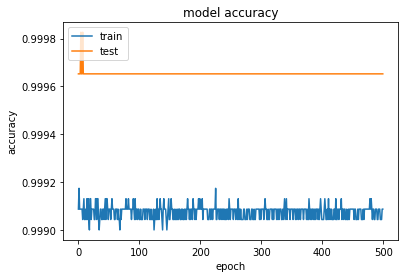

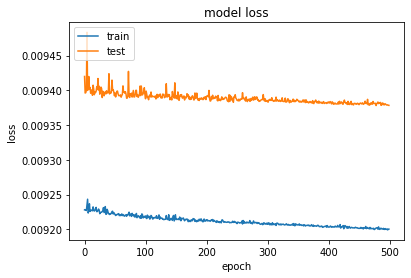

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
S4D_Her0.compile(loss      = tf.losses.MeanAbsolutePercentageError(),
                 metrics   = [mape_accuracy])

score = S4D_Her0.evaluate(log_data, trainer_data['Valorcomercial'].to_numpy(), verbose=1)

900/900 [==============================] - 2s 2ms/step - loss: 2.8073 - mape_accuracy: 96.6776


In [ ]:
res = S4D_Her0.predict(log_test[:10])

1/1 [==============================] - 0s 56ms/step


In [ ]:
S4D_Her0.save_weights(MASTER_MODEL)

In [ ]:
res[:,0].shape

(10,)

In [ ]:
tester_data[:10]

,FechadelInforme,TipodeVia,Estacionamiento,Categoriadelbien,Posicion,Numerodefrentes,Edad,Elevador,Estadodeconservacion,MetodoRepresentado,Areaterreno,Areaconstruccion,Valorcomercial
1,4.636207,4.771213e-01,-7.000000e+00,3.010300e-01,-7.0,-7.0,6.989700e-01,-7.0,0.778151,3.010300e-01,1.104487,1.972527,5.205305
2,4.639417,3.010300e-01,-7.000000e+00,4.771213e-01,-7.0,-7.0,1.204120e+00,-7.0,0.602060,4.342945e-08,2.204120,2.649724,5.469184
3,4.638829,4.771213e-01,4.342945e-08,3.010300e-01,-7.0,-7.0,4.342945e-08,-7.0,0.301030,3.010300e-01,0.595496,1.932271,5.096037
5,4.634064,4.771213e-01,-7.000000e+00,-7.000000e+00,-7.0,-7.0,3.010300e-01,-7.0,0.778151,3.010300e-01,0.748188,1.863680,4.987528
7,4.636949,4.342945e-08,4.342945e-08,6.989700e-01,-7.0,-7.0,1.477121e+00,-7.0,0.778151,3.010300e-01,0.555094,1.273001,4.085897
8,4.645579,4.342945e-08,-7.000000e+00,3.010300e-01,-7.0,-7.0,-7.000000e+00,-7.0,0.301030,3.010300e-01,0.732394,1.875640,4.756454
9,4.640263,6.020600e-01,-7.000000e+00,4.342945e-08,-7.0,-7.0,1.681241e+00,-7.0,0.778151,4.342945e-08,2.079181,2.286905,5.336790
10,4.641444,4.771213e-01,-7.000000e+00,4.342945e-08,-7.0,-7.0,7.781513e-01,-7.0,0.778151,4.342945e-08,3.669593,2.741742,6.846118
11,4.645216,-7.000000e+00,-7.000000e+00,3.010300e-01,-7.0,-7.0,-7.000000e+00,-7.0,0.301030,3.010300e-01,0.558709,1.701568,4.486898
13,4.629950,4.771213e-01,-7.000000e+00,7.781513e-01,-7.0,-7.0,1.863323e+00,-7.0,-7.000000,3.010300e-01,2.832049,2.563683,5.911244


In [ ]:
print(res)
#print(np.power(10,res.T[0]))

[[5.15574  ]
 [5.5156393]
 [5.146838 ]
 [5.048191 ]
 [4.50314  ]
 [5.061903 ]
 [5.264303 ]
 [6.209628 ]
 [4.478445 ]
 [5.932166 ]]


In [ ]:
print(test_gt[:10])

[ 160437  294567  124749   97169   12187   57076  217165 7016452   30683
  815163]
